In [491]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [492]:
%autoreload 2

In [501]:
%cd iRec

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/iREC


In [494]:
# load modules
import torch
import torch.distributions as dist
import pickle as pkl
import matplotlib.pyplot as plt
from models.BayesianLinRegressor import BayesLinRegressor
from rec.utils import compute_variational_posterior
import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth' : 2})
%config InlineBackend.figure_format='retina'

In [495]:
%matplotlib inline

In [496]:
def create_blr_problem(dim, seed, signal_std=1):
    
    initial_seed_target = seed
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                        prior_alpha=1,
                        signal_std=signal_std,
                        num_targets=10000,
                        seed=initial_seed_target)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    return blr, target

In [497]:
def compute_preds(d, blr_obj):
    preds = torch.zeros([0])
    sample_list = torch.tensor(d['compressed_samples'])
    for s in sample_list:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [498]:
def true_preds(blr_obj, seed=0):
    torch.manual_seed(seed)
    samples = blr_obj.weight_posterior.sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [499]:
def var_approx_preds(blr_obj, seed=0):
    torch.manual_seed(seed)
    samples = compute_variational_posterior(blr_obj.weight_posterior).sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [500]:
def compute_log_prob_empirical_mog(full_preds, blr):
    normal_dists = dist.normal.Normal(loc=full_preds, scale = signal_std)
    log_probs = normal_dists.log_prob(blr.regression_targets_test)
    sum_of_probs = torch.logsumexp(log_probs, dim=1)
    normalisation_constant = torch.log(torch.tensor(full_preds.shape[1]))
    gmm_log_prob_per_point = sum_of_probs - normalisation_constant
    gmm_log_prob = torch.sum(gmm_log_prob_per_point, dim=1)
    return gmm_log_prob

In [546]:
def make_gmm(preds):
    mix = dist.Categorical(torch.ones((preds.shape[1],)))
    comp = dist.Independent(dist.Normal(loc=preds, scale=signal_std), 1)
    gmm = dist.MixtureSameFamily(mix, comp)
    return gmm

# Point Estimate Results

## MSE

In [770]:
epsilons = [0., 0.05, 0.1, 0.15, 0.2]
dim = 5
beamwidth = 1
emp = []
vari = []
hard = False
for eps in epsilons:
    vari.append(pkl.load(open(f"PickledStuff/New_Exp/Dim{dim}/Variational_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
    emp.append(pkl.load(open(f"PickledStuff/New_Exp/Dim{dim}/Empirical_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))

In [771]:
blr_seed = 1
signal_std = 1e-1 if hard else 1
b, t = create_blr_problem(dim=dim, seed=blr_seed, signal_std=signal_std)

In [772]:
vari_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
emp_full_preds = torch.zeros(len(epsilons), 50, len(b.regression_targets_test))
for i, _ in enumerate(epsilons):
    emp_full_preds[i] = compute_preds(emp[i], b)
    vari_full_preds[i] = compute_preds(vari[i], b)

In [786]:
t.log_prob(torch.tensor(vari[-1]['compressed_samples'])).mean()

tensor(-9.0229)

In [763]:
var_gmm = make_gmm(vari_full_preds)
var_log_probs = var_gmm.log_prob(b.regression_targets_test)

In [764]:
torch.std(var_log_probs)

tensor(0.8675)

In [765]:
emp_gmm = make_gmm(emp_full_preds)
emp_log_probs = emp_gmm.log_prob(b.regression_targets_test)

In [766]:
torch.std(emp_log_probs)

tensor(0.9849)

In [767]:
((emp_full_preds - b.regression_targets_test) ** 2).mean(-1).mean(-1)

tensor([0.9828, 0.9802, 0.9769, 0.9765, 0.9761])

In [768]:
exact_log_probs = make_gmm(true_preds(b)[None]).log_prob(b.regression_targets_test)

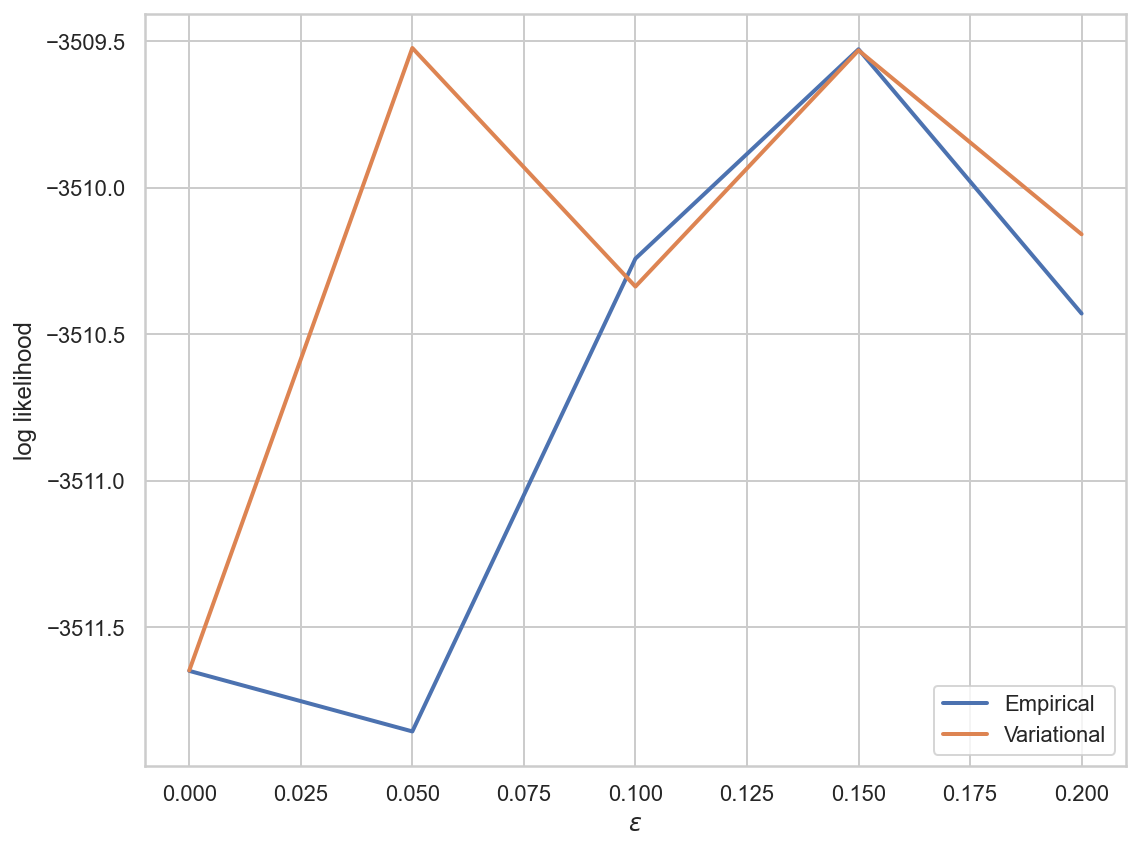

In [769]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_log_probs, label='Empirical')
ax.plot(epsilons, var_log_probs, label='Variational')
#ax.hlines(exact_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend(loc='lower right')
fig.tight_layout()